In [1]:
!pip install tf_keras_vis -q
!pip install tensorflow_addons -q

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from operator import itemgetter
import random

import keras
import tensorflow as tf
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.metrics import accuracy_score
from google.colab import files

### Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#load data from csv
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Innolab/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Innolab/train.csv")

Mounted at /content/drive


In [60]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Innolab")
import data_loader as dtl
from reorder_matrices_regions import reorder_matrices_regions
from viz_utils import ordered_regions

# import nn_modelling_utils as ut

### Preprocessing and preperation for CNN

In [5]:
test.head(2)

,ConnID,Repseudonym,siteid,age,visdat,sex,prmdiag,edyears,MEM_score,Apoe,IDs,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,1_19,1_20,1_21,1_22,1_23,1_24,1_25,1_26,1_27,1_28,1_29,1_30,...,237_243,237_244,237_245,237_246,238_239,238_240,238_241,238_242,238_243,238_244,238_245,238_246,239_240,239_241,239_242,239_243,239_244,239_245,239_246,240_241,240_242,240_243,240_244,240_245,240_246,241_242,241_243,241_244,241_245,241_246,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
0,249,46c3433d4,17,74,26.03.2018,1,2,13,-2.049570,1.0,249.0,0.574942,0.305049,0.162847,0.275940,0.019306,-0.019452,-0.156510,0.172117,-0.024951,0.606818,0.441176,0.084196,0.114680,0.521914,0.198896,0.475564,0.192633,0.307193,0.149679,0.464812,0.002804,0.411915,0.287092,0.335296,0.148400,0.475040,0.083054,0.172027,-0.042041,...,0.361282,0.681434,0.051703,0.356248,0.021860,0.151483,0.046508,0.380081,0.190855,0.532496,0.067998,0.159488,0.267005,0.247733,-0.007360,0.139081,0.111605,0.154606,0.293677,0.355418,0.622377,0.157162,0.485685,0.207092,0.651844,0.124603,0.476194,0.08167,-0.140328,0.017211,0.017766,0.713473,0.160039,0.407091,0.193513,-0.086803,0.171596,0.276317,0.494943,0.344752
1,577,b18d729af,11,76,15.06.2016,0,2,11,-1.189132,1.0,577.0,0.776586,0.467788,0.164115,0.321399,0.203079,0.344261,-0.015906,0.436849,0.470886,0.626489,0.487020,0.106208,-0.003195,0.091799,0.050809,0.650164,0.355355,0.123783,-0.136501,0.252601,0.134610,0.301837,0.111609,0.667055,0.223697,-0.085763,-0.107308,0.598378,0.452597,...,0.525016,0.778868,0.368278,0.479114,0.447165,0.711927,0.669327,0.576660,0.367612,0.577063,0.239827,0.515898,0.203085,0.514212,0.144925,0.366177,0.213815,0.856538,0.582982,0.621164,0.785972,0.603620,0.814200,0.049528,0.382625,0.495069,0.316740,0.37590,0.209996,0.402320,0.464287,0.413642,-0.051788,0.284676,0.837725,0.315466,0.441045,0.197800,0.410294,0.692895


In [6]:
scaler = StandardScaler()
def preprocess_conn_matrix(df, train_data = True):
    #create target
    y, X = dtl.preprocess_data(df)
    y = np.array(y, dtype=np.float32)

    #drop columns
    cols_to_drop = ["MEM_score", "Apoe", "age", "sex", "edyears"]
    X.drop(columns=cols_to_drop, inplace = True)
    
    if train_data:
        scaler.fit_transform(X)
    else:
        scaler.transform(X)

    #turn array to matrix
    n_c = dtl.flat_to_mat(X.iloc[0,:]).shape[0]
    n_train = len(X)
    X_train_2d = np.zeros(n_train*n_c*n_c).reshape(n_train,n_c,n_c)

    for i in range(n_train):
      X_train_2d[i] = dtl.flat_to_mat(X.iloc[i,:])

    stacked = np.stack(reorder_matrices_regions(X_train_2d, network = 'yeo7'), axis = 0)

    #reshape data
    X_train_2d = stacked.reshape(stacked.shape[0], stacked.shape[1], stacked.shape[2], 1)

    return X_train_2d, y

In [7]:
def data_augmentation_gaussian(X,y, scale = .17):
    X_noise = X.copy()
    y_noise = y.copy()

    for i in range(X.shape[0]):
        #add gaussian noise
        noise = np.random.normal(loc = 0, scale = scale, size = (X.shape[1], X.shape[2], 1))
        X_noise[i] = X[i] + np.triu(noise, k=1).reshape(X.shape[1], X.shape[2], 1) + np.triu(noise, k=1).T.reshape(X.shape[1], X.shape[2], 1)

    return np.concatenate((X, X_noise), axis = 0), np.concatenate((y, y_noise), axis = 0)

In [8]:
X_train, y_train = preprocess_conn_matrix(train, train_data = True)
X_test, y_test = preprocess_conn_matrix(test, train_data = False)

In [15]:
X_train_aug,y_train_aug = data_augmentation_gaussian(X_train,y_train, scale = .07)

In [16]:
X_train_aug.shape

(600, 246, 246, 1)

In [34]:
# Train val split
shuffled_indices = list(range(len(X_train_aug)))
random.shuffle(shuffled_indices)

train_idxs = shuffled_indices[:500]
val_idxs = shuffled_indices[500:]

val_x = X_train_aug[val_idxs]
val_y = y_train_aug[val_idxs]

train_x = X_train_aug[train_idxs]
train_y = y_train_aug[train_idxs]

In [ ]:
## TODO: Implement CCNN https://www.researchgate.net/publication/318652568_Resting_State_fMRI_Functional_Connectivity-Based_Classification_Using_a_Convolutional_Neural_Network_Architecture/link/5978a095aca27203ecc4a2a1/download 
## Write training routine
# validation batch
# add visualization

### Models

In [18]:
def ccnn_model(input_dim, output_dim: int = 1, opt = Adam(), loss = "binary_crossentropy"):

    filter_num1 = 16
    filter_num2 = 32 

    # create model
    input = Input(shape=input_dim, name='input')
    conv1 = Conv2D(filters=filter_num1, kernel_size=(input_dim[0], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_initializer='he_uniform', activation='relu', name='conv1')(input)
    conv2 = Conv2D(filters=filter_num2, kernel_size=(1, input_dim[1]), strides=(1, 1),
                                  padding='valid',
                                  kernel_initializer='he_uniform', activation='relu', name='conv2')(conv1)
    
    # x = Conv2D(filters=filter_num1, kernel_size=(5, 5), strides=(1, 1),
    #                               padding='valid',
    #                               kernel_initializer='he_uniform', activation='relu', name='conv1')(input)
    # x = Conv2D(filters=filter_num2, kernel_size=(3, 3), strides=(1, 1),
    #                               padding='valid',
    #                               kernel_initializer='he_uniform', activation='relu', name='conv2')(x)

    x = Flatten()(conv2)


    #dense part of the network
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.4)(x)
    out = Dense(output_dim, activation="sigmoid")(x)

    model = Model(inputs=[input], outputs=out)
    #model = Model(inputs=[first_input, second_input], outputs=out)
    model.compile(loss=loss,
                  optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [23]:
def standard_cnn_model(input_dim, output_dim: int = 1, opt = Adam(), loss = "binary_crossentropy"):

    filter_num1 = 32
    filter_num2 = 32
    filter_num3 = 32

    # create model
    input = Input(shape=input_dim, name='input')
    x = Conv2D(filters=filter_num1, kernel_size=(3,3), strides=(1, 1),
                                  padding='valid',
                                  kernel_initializer='he_uniform', activation='relu', name='conv1')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=filter_num2, kernel_size=(3,3), strides=(1, 1),
                                  padding='valid',
                                  kernel_initializer='he_uniform', activation='relu', name='conv2')(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Conv2D(filters=filter_num3, kernel_size=(3,3), strides=(1, 1),
                                  padding='valid',
                                  kernel_initializer='he_uniform', activation='relu', name='conv3')(x)

    x = Flatten()(x)
    #dense part of the network
    x = Dense(32, activation="relu")(x)
    
    out = Dense(output_dim, activation="sigmoid")(x)

    model = Model(inputs=[input], outputs=out)
    #model = Model(inputs=[first_input, second_input], outputs=out)
    model.compile(loss=loss,
                  optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

### Training

In [21]:
batch_size = 8
epochs = 30
lr = 0.001
opt = AdamW(learning_rate = lr, weight_decay = 0.001)
input_shape_2d = (X_train_aug.shape[1], X_train_aug.shape[2], 1)

In [24]:
ccnn = ccnn_model(input_dim = input_shape_2d, output_dim = 1, opt = opt)
standard_cnn = standard_cnn_model(input_dim = input_shape_2d, output_dim = 1, opt = opt)

print(ccnn.summary())
print(standard_cnn.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 246, 246, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 1, 246, 16)        3952      
                                                                 
 conv2 (Conv2D)              (None, 1, 1, 32)          125984    
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65  

In [35]:
train_2d = tf.data.Dataset.from_tensor_slices((train_x, train_y))

SHUFFLE_BUFFER_SIZE = 100

train_2d_batch = train_2d.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)

In [36]:
ccnn_model_fit = ccnn.fit(train_2d_batch, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

Epoch 1/30
63/63 [==============================] - 3s 29ms/step - loss: 0.6203 - binary_accuracy: 0.6480 - false_negatives_1: 119.0000 - val_loss: 0.6465 - val_binary_accuracy: 0.5500 - val_false_negatives_1: 44.0000
Epoch 2/30
63/63 [==============================] - 2s 24ms/step - loss: 0.4725 - binary_accuracy: 0.8060 - false_negatives_1: 72.0000 - val_loss: 0.5667 - val_binary_accuracy: 0.6700 - val_false_negatives_1: 29.0000
Epoch 3/30
63/63 [==============================] - 2s 25ms/step - loss: 0.3144 - binary_accuracy: 0.8820 - false_negatives_1: 41.0000 - val_loss: 0.3793 - val_binary_accuracy: 0.8300 - val_false_negatives_1: 14.0000
Epoch 4/30
63/63 [==============================] - 2s 24ms/step - loss: 0.1415 - binary_accuracy: 0.9680 - false_negatives_1: 13.0000 - val_loss: 0.4059 - val_binary_accuracy: 0.8000 - val_false_negatives_1: 18.0000
Epoch 5/30
63/63 [==============================] - 2s 25ms/step - loss: 0.0867 - binary_accuracy: 0.9760 - false_negatives_1: 9.00

In [37]:
standard_cnn_fit = standard_cnn.fit(train_2d_batch, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

58/63 [==========================>...] - ETA: 2s - loss: 0.3953 - binary_accuracy: 0.8362 - false_negatives_2: 46.0000

KeyboardInterrupt: ignored

### Evaluation

In [39]:
y_pred = np.round(ccnn.predict(X_test))

In [41]:
accuracy_score(y_test, y_pred)

0.6712328767123288

### Save Model

In [50]:
!mkdir -p saved_model
ccnn.save('saved_model/ccnn_v1') 

INFO:tensorflow:Assets written to: saved_model/ccnn_v1/assets


### Visualization

In [42]:
X = X_test[0:3]

In [43]:
X.shape

(3, 246, 246, 1)

In [44]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [45]:
replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [46]:
def score_function(output):
    # The `output` variable refers to the output of the model,
    return [i[0] for i in output]
    #return (output[0][0], output[1][0], output[2][0] )

In [61]:
ordered_region = ordered_regions()

### Saliency Map

In [47]:
from tf_keras_vis.saliency import Saliency
saliency = Saliency(ccnn,
                    model_modifier=replace2linear,
                    clone=True)

In [48]:
# Generate saliency map
saliency_map = saliency(score_function, X)

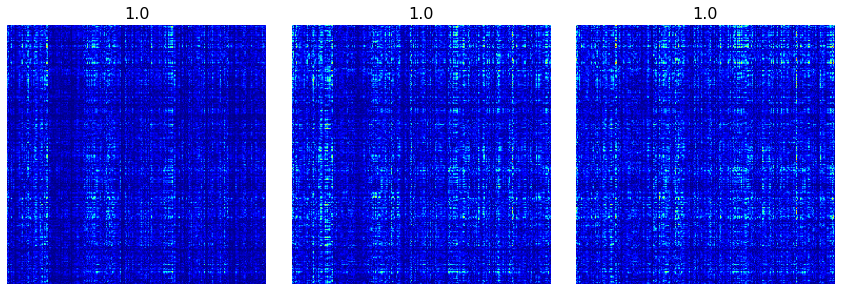

In [49]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_test[0:3]):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

### Grad Cam

In [ ]:
# Create Gradcam object
gradcam = Gradcam(ccnn,
                  model_modifier=replace2linear,
                  clone=True)


In [ ]:
# Generate heatmap with GradCAM
cam = gradcam(score_function,
              X,
              penultimate_layer=-1)

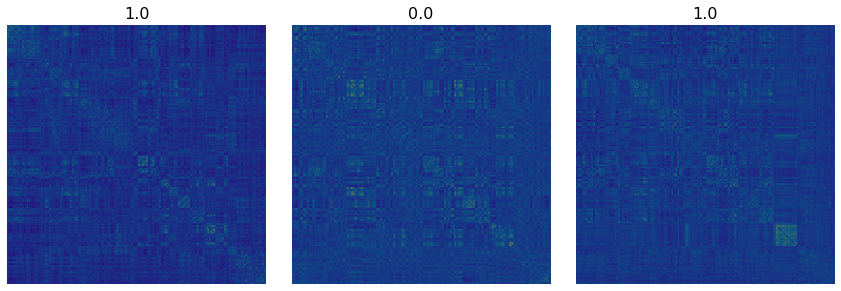

In [ ]:
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_train[0:3]):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i].reshape((246,246)))
    ax[i].imshow(cam[i], cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

(246, 246)

### Grad Cam ++

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)


In [ ]:
# Generate heatmap with GradCAM++
cam = gradcam(score_function,
              X,
              penultimate_layer=-1)


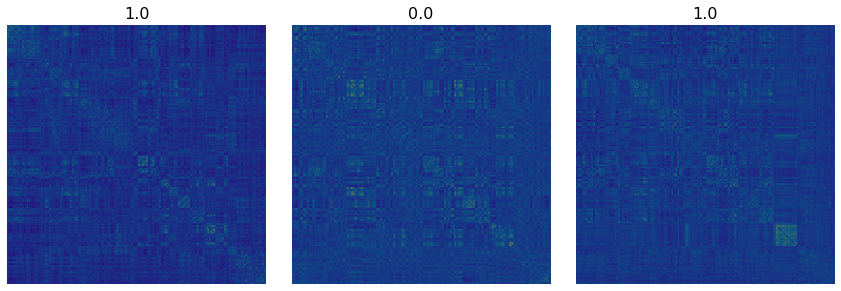

In [ ]:
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_train[0:3]):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i].reshape((246,246)))
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

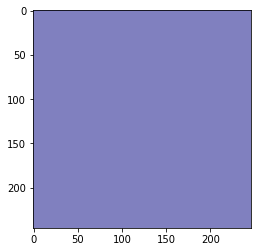

In [ ]:
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(heatmap, cmap='jet', alpha=0.5)